In [419]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import os
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore", message="Glyph 12 missing from current font.")

from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA 
from sklearn.decomposition import FastICA as ICA 
from sklearn.random_projection import GaussianRandomProjection as GRP
from sklearn.ensemble import RandomForestClassifier as RFC

from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import confusion_matrix


# Evaluation
from sklearn.metrics import homogeneity_score, completeness_score, \
            v_measure_score, adjusted_rand_score, adjusted_mutual_info_score

Data #1

In [2]:
data_polling = pd.read_stata("Data/cumulative_2006_2018.dta")

In [3]:
inputs = ['year','st','gender', 'age', 'race', 'hispanic', 'educ', 'faminc', 'marstat', 'economy_retro', 'newsint','approval_pres']
targets = ['pid3']

keep = inputs + targets

data_polling = data_polling[(data_polling.year == 2018) & (data_polling.pid3.isin(['Democrat','Republican']) )]

polling = data_polling[keep]

In [4]:
polling.dropna(axis=0, how='any',inplace=True)

/Users/amandahutter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [5]:
pd.options.mode.chained_assignment = None  # default='warn'

polling['age_band'] = np.NaN
polling.loc[ (polling['age'] >= 18) & (polling['age'] <= 29), 'age_band'] = 'Young'
polling.loc[ (polling['age'] >= 30) & (polling['age'] <= 49), 'age_band'] = 'Lower-Middle'
polling.loc[ (polling['age'] >= 50) & (polling['age'] <= 69), 'age_band'] = 'Upper-Middle'
polling.loc[ (polling['age'] >= 70) , 'age_band'] = 'Old'

polling.loc[ polling['pid3'] == "Democrat", "Dem_Ind"] = 1
polling.loc[ polling['pid3'] == 'Republican', "Dem_Ind"] = 0
polling['Dem_Ind'] = polling['Dem_Ind'].astype(int)

categorical_polling = ['st','gender', 'age_band', 'race', 'hispanic', 'educ', 'faminc', 'marstat', 'economy_retro', 'newsint','approval_pres']

In [6]:
polling.head()

,year,st,gender,age,race,hispanic,educ,faminc,marstat,economy_retro,newsint,approval_pres,pid3,age_band,Dem_Ind
392756,2018,OH,Female,58,White,No,Post-Grad,150k+,Married,Stayed About The Same,Only Now And Then,Approve / Somewhat Approve,Republican,Upper-Middle,0
392757,2018,KY,Female,66,White,No,Post-Grad,10k - 20k,Divorced,Stayed About The Same,Most Of The Time,Strongly Disapprove,Democrat,Upper-Middle,1
392758,2018,AZ,Female,88,White,No,High School Graduate,20k - 30k,Widowed,Gotten Much Better,Some Of The Time,Approve / Somewhat Approve,Republican,Old,0
392760,2018,NC,Male,71,White,No,High School Graduate,50k - 60k,Married,Gotten Much Better,Some Of The Time,Strongly Approve,Republican,Old,0
392761,2018,PA,Male,86,White,No,4-Year,60k - 70k,Widowed,Gotten Better / Somewhat Better,Most Of The Time,Strongly Approve,Republican,Old,0


In [7]:
small_polling = polling.sample(n=10000, random_state = 42)

X_polling = small_polling[categorical_polling]

y_polling = small_polling.loc[:,'Dem_Ind']

Data #2

In [8]:
# Originall Retrieved From: http://archive.ics.uci.edu/ml/datasets/Adult
# CSV Retrieved From: https://www.kaggle.com/uciml/adult-census-income
# URL: https://drive.google.com/file/d/1wuWJPeacMhHQSXdITZx1_pktoU-ZRb8n/view?usp=sharing
data_income = pd.read_csv("Data/adult.csv")

print(data_income.shape)

(32561, 15)


In [9]:
# Response Variable 
data_income.loc[ data_income['income'] == ">50K", "income"] = 1
data_income.loc[ data_income['income'] == '<=50K', "income"] = 0
data_income['income'] = data_income['income'].astype(int)

In [10]:
# Feature Engineering
data_income['native_USA'] = 0 
data_income.loc[ data_income['native.country'] == "United-States", "native_USA"] = 1
data_income.loc[ data_income['native.country'] != "United-States", "native_USA"] = 0

In [11]:
data_income['native_USA'].value_counts()

1    29170
0     3391
Name: native_USA, dtype: int64

In [12]:
data_income['age_band'] = np.NaN
data_income.loc[ (data_income['age'] <= 29), 'age_band'] = 'Young'
data_income.loc[ (data_income['age'] >= 30) & (data_income['age'] <= 49), 'age_band'] = 'Lower-Middle'
data_income.loc[ (data_income['age'] >= 50) & (data_income['age'] <= 69), 'age_band'] = 'Upper-Middle'
data_income.loc[ (data_income['age'] >= 70) , 'age_band'] = 'Old'

In [13]:
data_income['hours_band'] = np.NaN
data_income.loc[ (data_income['hours.per.week']) < 40, "hours_band"] = 'Low'
data_income.loc[ (data_income['hours.per.week']) == 40, "hours_band"] = 'Average'
data_income.loc[ (data_income['hours.per.week']) > 40, "hours_band"] = 'High'

In [14]:
data_income['hours_band'].value_counts()

Average    15217
High        9581
Low         7763
Name: hours_band, dtype: int64

In [15]:
categorical_income = ['workclass','education','marital.status','occupation','relationship','race','sex','native_USA','age_band','hours_band']


In [16]:
data_income['income'].value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [17]:
small_income = data_income.sample(10000,random_state=42)

In [18]:
X_income = small_income[categorical_income]

y_income = small_income.loc[:,'income']


General Use Functions

In [19]:
from sklearn.preprocessing import OneHotEncoder

def prep_data(X, y, categoricalVars):

    encoder = OneHotEncoder(sparse=False)
    X_encoded = pd.DataFrame(encoder.fit_transform(X[categoricalVars]))
    X_encoded.columns = encoder.get_feature_names(categoricalVars)
    X.drop(categoricalVars, axis = 1, inplace = True)
    if X.shape[1] > 0:
        OH_X = pd.concat([X, pd.DataFrame(X_encoded, index=X.index)], axis = 1)
    else:
        OH_X = X_encoded 
        
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(OH_X, y, test_size = .30, train_size = .70, random_state = 42)
    return(X_Train, X_Test, Y_Train, Y_Test)

In [20]:
X_Train_Polling, X_Test_Polling, Y_Train_Polling, Y_Test_Polling = prep_data(X_polling, y_polling, categorical_polling)

In [21]:
X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income = prep_data(X_income, y_income, categorical_income)

### Tutorial for K-Means

Selecting the Number of clusters with silhouette analysis on KMeans Clustering

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

- Silhoutte is a metric used to measure the separation distance between clusters 
- Silhoutte measure ranges from -1 to 1. 
- Silhoutte values near +1: good, sample is far from neighboring cluster
- Silhoutte values near 0: Samples is on or near the decision boundary between two clusters 
- Silhoutte values < 0: Bad, Samples may be assigned to wrong cluster 
- Vary the n_clusters and examine silhoutte metric 

## Step 1

For KMeans, consider these metrics:
- Inertia (TSS): MINIMIZE the Inertia, or the distance from points to their centers. Find the point where adding more clusters does not decrease the inertia, and use this as optimal clusters
- Silhoutte Score: MAXIMIZE the SScore, this shows us how separate clusters are from another 

#### KMeans Data 1

In [290]:
import matplotlib.cm as cm

def run_kmeans(X_Data, range_num_clusters, title):
      
    n_clusters_list = []
    inertia_list = []
    avg_silhouette_list = []
    
    for n_clusters in range_num_clusters:
        kmeans_clusterer =  KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10, random_state = 42)
        kmeans_cluster_labels = kmeans_clusterer.fit_predict(X_Data)
        kmeans_silhouette_avg = silhouette_score(X_Data, kmeans_cluster_labels)

        
        n_clusters_list.append(n_clusters)
        inertia_list.append(kmeans_clusterer.inertia_)
        avg_silhouette_list.append(kmeans_silhouette_avg)
        
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(n_clusters_list, inertia_list, 'blue', label = 'Inertia')
    ax1.set_xlabel('Number of Clusters')
    ax1.plot([], [], 'green', label = 'Silhouette Score')
    ax1.legend()
    ax1.set_ylabel('Inertia')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(n_clusters_list, avg_silhouette_list, 'green', label = 'Silhouette Score')
    ax2.set_ylabel('Avg. Silhouette Score')
    plt.grid(False)

    plt.title("The Effect of Number of Clusters \non Inertia and Avg. Silhouette Score  \n for " + title + " with K-Means")
    
    fig.tight_layout()
    plt.show()
    

#### Data # 1

<Figure size 432x288 with 0 Axes>

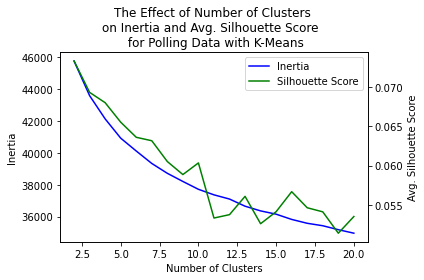

None
325.85654520988464


In [31]:
import time

start = time.time()

labels = run_kmeans(X_Train_Polling, np.arange(2, 21, 1) , "Polling Data")
print(labels)

end = time.time()
elapsed = end-start
print(elapsed)

<Figure size 432x288 with 0 Axes>

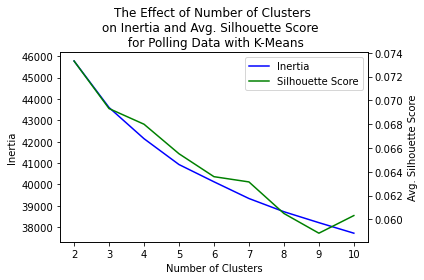

None
9.566987037658691


In [32]:
import time

start = time.time()

labels = run_kmeans(X_Train_Polling, np.arange(2, 11, 1) , "Polling Data")
print(labels)

end = time.time()
elapsed = end-start
print(elapsed)

<Figure size 432x288 with 0 Axes>

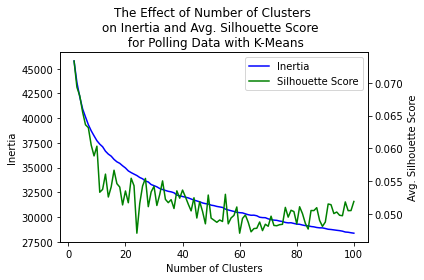

None
792.3788840770721


In [33]:
import time

start = time.time()

labels = run_kmeans(X_Train_Polling, np.arange(2, 101, 1) , "Polling Data")
print(labels)

end = time.time()
elapsed = end-start
print(elapsed)

- KMEANS, Data 1, the elbow appears around 10 clusters

#### KMeans Data 2

#### Data #2

<Figure size 432x288 with 0 Axes>

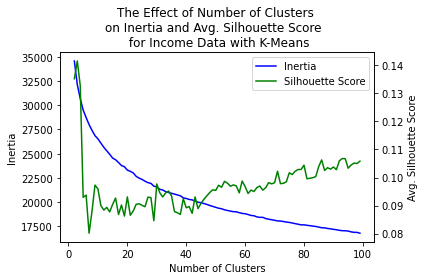

257.9900960922241


In [34]:
start = time.time()

run_kmeans(X_Train_Income, np.arange(2, 100, 1) , "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

<Figure size 432x288 with 0 Axes>

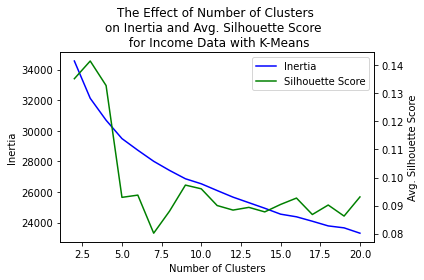

19.088643074035645


In [35]:
start = time.time()

run_kmeans(X_Train_Income, np.arange(2, 21, 1) , "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

- KMEANS, Data 2, the best result seems around 8 clusters

### EM Data 1

In [420]:
from sklearn.mixture import GaussianMixture as EM

def run_em(X_Data, k_list, title, cov_type):
    
    aic_list = []
    bic_list = []
    avg_silhouette_list = []
    n_components_list = []
    
    for k in k_list:
        em = EM(n_components = k, covariance_type = cov_type, n_init = 1, init_params = 'kmeans', random_state = 42)
        em_labels = em.fit_predict(X_Data)
        
        n_components_list.append(k)
        avg_silhouette_list.append(silhouette_score(X_Data, em_labels))
        aic_list.append(em.aic(X_Data))
        bic_list.append(em.bic(X_Data))
        
    fig, ax1 = plt.subplots()
    ax1.plot(n_components_list, aic_list, 'blue', label = 'AIC')
    ax1.plot(n_components_list, bic_list, 'green', label = 'BIC')
    ax1.set_xlabel('Number of Components')
    ax1.plot([], [], 'orange', label = 'Silhouette Score')
    ax1.legend()
    ax1.set_ylabel('AIC/BIC Curves')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(n_components_list, avg_silhouette_list, 'orange', label = 'Silhouette Score')
    ax2.set_ylabel('Avg. Silhouette Score')
    plt.grid(False)

    plt.title("The Effect of Number of Components \non BIC/AIC and Avg. Silhouette Score  \nfor " + title + " with EM, "+ cov_type+" Covariance")
    
    fig.tight_layout()
    plt.show()


Covariance type: full


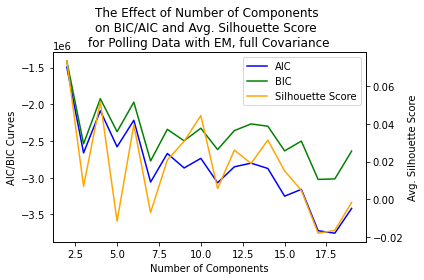

Covariance type: tied


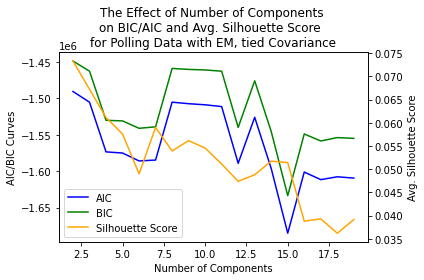

Covariance type: diag


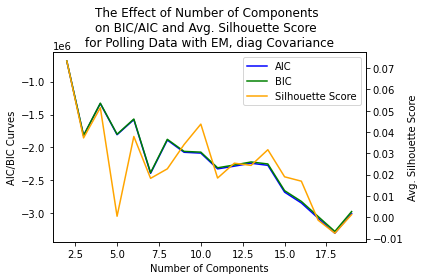

Covariance type: spherical


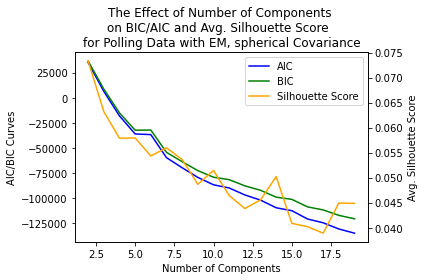

In [421]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

for cv in covariance_type:
    print("Covariance type:", cv)
    run_em(X_Train_Polling, np.arange(2, 20, 1), "Polling Data", cv)

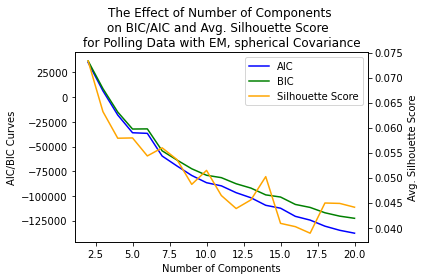

In [422]:
run_em(X_Train_Polling, np.arange(2, 21, 1), "Polling Data", 'spherical')

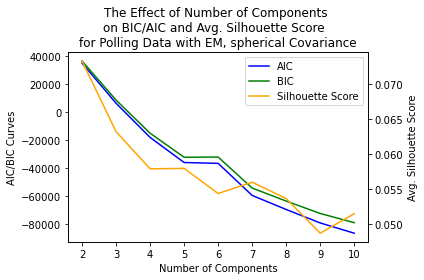

In [423]:
run_em(X_Train_Polling, np.arange(2, 11, 1), "Polling Data", 'spherical')

Data 1:
- Silhouette Max score occurs for n_components = 2, for all cov_types, at 0.0733
- Highest Silhouette occurs for covariance type = Spherical, highest floor of 0.449 
- BIC/AIC elbow method occurs for n_components = 5, for Spherical, or 3 for others 

#### EM Data #2

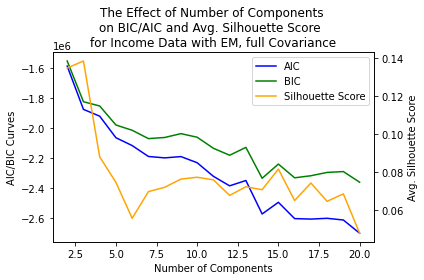

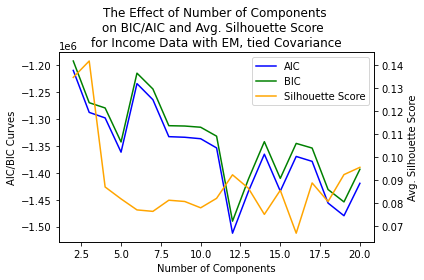

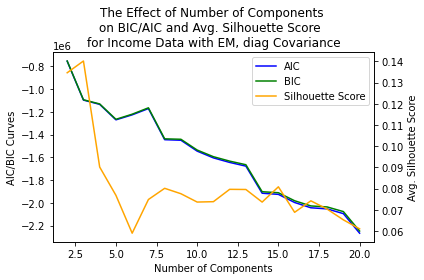

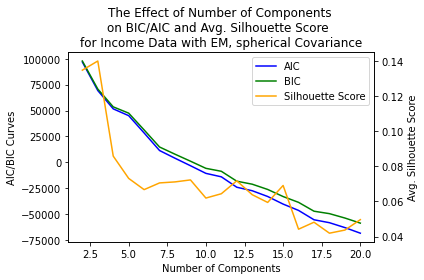

In [424]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

for cv in covariance_type:
    run_em(X_Train_Income, np.arange(2, 21, 1), "Income Data", cv)

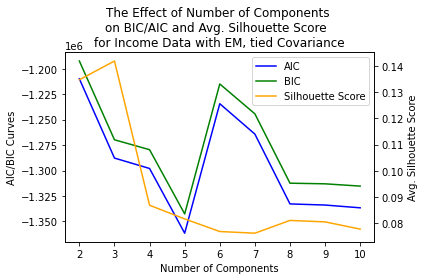

In [425]:
run_em(X_Train_Income, np.arange(2, 11, 1), "Income Data", 'tied')

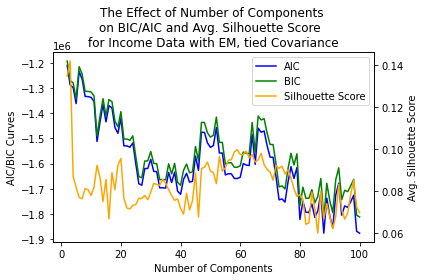

In [426]:
run_em(X_Train_Income, np.arange(2, 101, 1), "Income Data", 'tied')

Data 2:
- Silhouette Max score occurs for n_components = 3 at 0.142
- Highest Silhouette occurs for covariance type = 'tied'
- BIC/AIC elbow method occurs for n_components = 5, heuristic method shows where decrease slows down

### Evaluate Choice of K for Clustering Methods 

In [349]:

def eval_kmeans(X_Train, Y_Train, X_Test, Y_Test, opt_clusters):
        
        kmeans =  KMeans(n_clusters = opt_clusters, init = 'k-means++', n_init = 10, random_state = 42)
        kmeans_labels = kmeans.fit_predict(X_Train)
        
        print("Train Set:")
        print("Silhouette Score:",silhouette_score(X_Train, kmeans_labels))
        print("Homogeneity:",homogeneity_score(Y_Train, kmeans_labels))
        print("Completeness:",completeness_score(Y_Train, kmeans_labels))
        print("V Measure:", v_measure_score(Y_Train, kmeans_labels))
        print("Adj Rand Score:", adjusted_rand_score(Y_Train, kmeans_labels))
        print("Adj Mutual Info:", adjusted_mutual_info_score(Y_Train, kmeans_labels))
        
        kmeans =  KMeans(n_clusters = opt_clusters, init = 'k-means++', n_init = 10, random_state = 42)
        kmeans_labels = kmeans.fit_predict(X_Test)
        kmeans_silhouette_avg = silhouette_score(X_Test, kmeans_labels)
        
        print("Test Set:")
        print("Silhouette Score:",silhouette_score(X_Test, kmeans_labels))
        print("Homogeneity:",homogeneity_score(Y_Test, kmeans_labels))
        print("Completeness:",completeness_score(Y_Test, kmeans_labels))
        print("V Measure:", v_measure_score(Y_Test, kmeans_labels))
        print("Adj Rand Score:", adjusted_rand_score(Y_Test, kmeans_labels))
        print("Adj Mutual Info:", adjusted_mutual_info_score(Y_Test, kmeans_labels))
        
        
        

In [350]:
eval_kmeans(X_Train_Polling, Y_Train_Polling, X_Test_Polling, Y_Test_Polling, 2)

Train Set:
Silhouette Score: 0.07331336447494478
Homogeneity: 0.008821292632997324
Completeness: 0.008972658227586684
V Measure: 0.0088963316288281
Adj Rand Score: 0.01709024619527017
Adj Mutual Info: 0.008791921261694263
Test Set:
Silhouette Score: 0.07346696389543876
Homogeneity: 0.016745650656315333
Completeness: 0.017056795379209403
V Measure: 0.01689979100543872
Adj Rand Score: 0.029641266849957076
Adj Mutual Info: 0.016657737306072895


In [351]:
eval_kmeans(X_Train_Income, Y_Train_Income, X_Test_Income, Y_Test_Income, 3)

Train Set:
Silhouette Score: 0.14151855344798583
Homogeneity: 0.17273136094468702
Completeness: 0.08773599668370936
V Measure: 0.11636589128866319
Adj Rand Score: 0.03848719034535237
Adj Mutual Info: 0.11621082581836326
Test Set:
Silhouette Score: 0.14361456047306315
Homogeneity: 0.20159954769546645
Completeness: 0.10380040619231296
V Measure: 0.13704072101245557
Adj Rand Score: 0.0475234576448244
Adj Mutual Info: 0.13668830536757623


In [352]:

def eval_em(X_Train, Y_Train, X_Test, Y_Test, opt_clusters, cov_type):
        
        em = EM(n_components = opt_clusters, covariance_type = cov_type, n_init = 1, init_params = 'kmeans', random_state = 42)
        em_labels = em.fit_predict(X_Train)
        
        print("Train Set:")
        print("Silhouette Score:",silhouette_score(X_Train, em_labels))
        print("Homogeneity:",homogeneity_score(Y_Train, em_labels))
        print("Completeness:",completeness_score(Y_Train, em_labels))
        print("V Measure:", v_measure_score(Y_Train, em_labels))
        print("Adj Rand Score:", adjusted_rand_score(Y_Train, em_labels))
        print("Adj Mutual Info:", adjusted_mutual_info_score(Y_Train, em_labels))

        em = EM(n_components = opt_clusters, covariance_type = cov_type, n_init = 1, init_params = 'kmeans', random_state = 42)
        em_labels = em.fit_predict(X_Test)
        
        print("Test Set:")
        print("Silhouette Score:",silhouette_score(X_Test, em_labels))
        print("Homogeneity:",homogeneity_score(Y_Test, em_labels))
        print("Completeness:",completeness_score(Y_Test, em_labels))
        print("V Measure:", v_measure_score(Y_Test, em_labels))
        print("Adj Rand Score:", adjusted_rand_score(Y_Test, em_labels))
        print("Adj Mutual Info:", adjusted_mutual_info_score(Y_Test, em_labels))
        
        
        

In [353]:
eval_em(X_Train_Polling, Y_Train_Polling, X_Test_Polling, Y_Test_Polling, 5, "spherical")

Train Set:
Silhouette Score: 0.05794035772127549
Homogeneity: 0.42238449911962
Completeness: 0.1822074770016123
V Measure: 0.25459025904684984
Adj Rand Score: 0.20367186450490643
Adj Mutual Info: 0.25440245731239586
Test Set:
Silhouette Score: 0.05508206262617595
Homogeneity: 0.47241026664674196
Completeness: 0.20172787683103924
V Measure: 0.2827263848095054
Adj Rand Score: 0.21917490132564066
Adj Mutual Info: 0.2823071177140019


In [354]:
eval_em(X_Train_Income, Y_Train_Income, X_Test_Income, Y_Test_Income, 3, "tied")

Train Set:
Silhouette Score: 0.14180683013810363
Homogeneity: 0.15852832722221677
Completeness: 0.08047098553765634
V Measure: 0.10675286535258763
Adj Rand Score: 0.058896883853514756
Adj Mutual Info: 0.10659617867583088
Test Set:
Silhouette Score: 0.13324334918628838
Homogeneity: 0.16245251594208243
Completeness: 0.08346069665392755
V Measure: 0.11026979811762633
Adj Rand Score: 0.054673321849903776
Adj Mutual Info: 0.1099069788938204


In [395]:
def pca_chart_kmeans(X_Data, Optimal_Num_Clusters, title):
    # From SKLearn example: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

    reduced_data = PCA(n_components=2).fit_transform(X_Data)
   
    kmeans = KMeans(init='k-means++', n_clusters=Optimal_Num_Clusters, n_init=10)
    kmeans.fit(reduced_data)

    ###
    h = 0.02

    x_min, x_max = reduced_data[:,0].min()-0.25, reduced_data[:,0].max() +0.25
    y_min, y_max = reduced_data[:,1].min()-0.25, reduced_data[:,1].max() +0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
    plt.title("K-Means Clustering on Top 2 PCA Dimensions \nfor " + title)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks()
    plt.yticks()
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

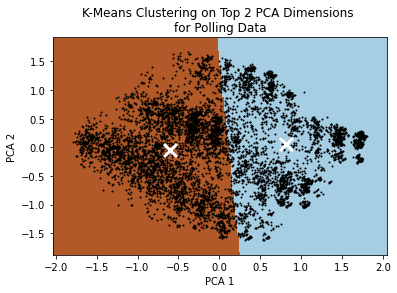

In [396]:
pca_chart_kmeans(X_Train_Polling, 2, "Polling Data")

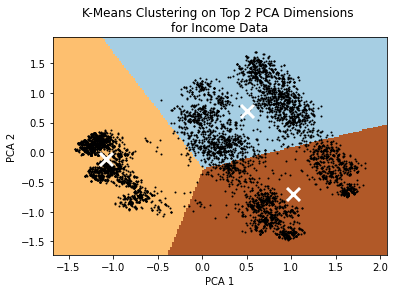

In [399]:
pca_chart_kmeans(X_Train_Income, 3, "Income Data")

In [413]:
def pca_chart_em(X_Data, Optimal_Num_Clusters, cov_type, title):
    # From SKLearn example: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

    reduced_data = PCA(n_components=2).fit_transform(X_Data)
    
    em = EM(n_components = Optimal_Num_Clusters, covariance_type = cov_type, n_init = 1, init_params = 'kmeans', random_state = 42)
    em.fit(reduced_data)   

    ###
    h = 0.02

    x_min, x_max = reduced_data[:,0].min()-0.25, reduced_data[:,0].max() +0.25
    y_min, y_max = reduced_data[:,1].min()-0.25, reduced_data[:,1].max() +0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = em.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    #centroids = em.cluster_centers_
    #plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
    plt.title("EM Clustering on Top 2 PCA Dimensions \nfor " + title)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks()
    plt.yticks()
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

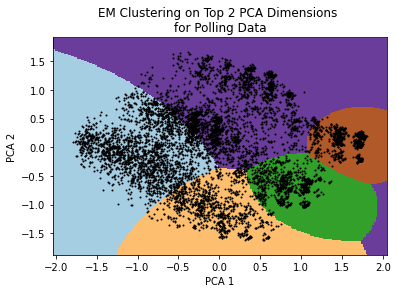

In [414]:
pca_chart_em(X_Train_Polling, 5, "spherical", "Polling Data")

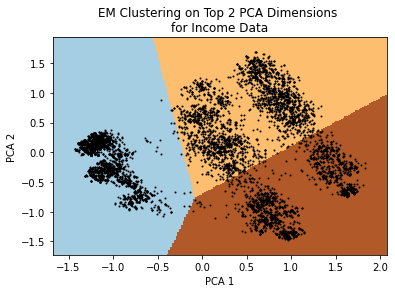

In [415]:
pca_chart_em(X_Train_Income, 3, "tied", "Income Data")

In [361]:
from sklearn.manifold import TSNE 
import seaborn as sns
import time 

def make_tsne_3D(X_Data, Y_Data):
    start = time.time()
    tsne = TSNE(n_components = 3, verbose =1, perplexity =40, n_iter=300)
    tsne_results = tsne.fit_transform(X_Data)
    tsne_results = pd.DataFrame(tsne_results, columns = ['tsne_1', 'tsne_2','tsne_3'])
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-start))
    return tsne_results

In [362]:
tsne_results = make_tsne_3D(X_Train_Polling, Y_Train_Polling)

print(tsne_results.head())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.082s...
[t-SNE] Computed neighbors for 7000 samples in 6.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.916052
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.790756
[t-SNE] KL divergence after 300 iterations: 3.355951
t-SNE done! Time elapsed: 16.717705011367798 seconds
     tsne_1    tsne_2    tsne_3
0 -0.178325 -7.210135  1.963586
1  0.848515 -4.002488  3.514435
2  0.000782  5.268302  0.322765
3  0.045424 -0.211956  2.659754
4  0.004588  2.561265 -

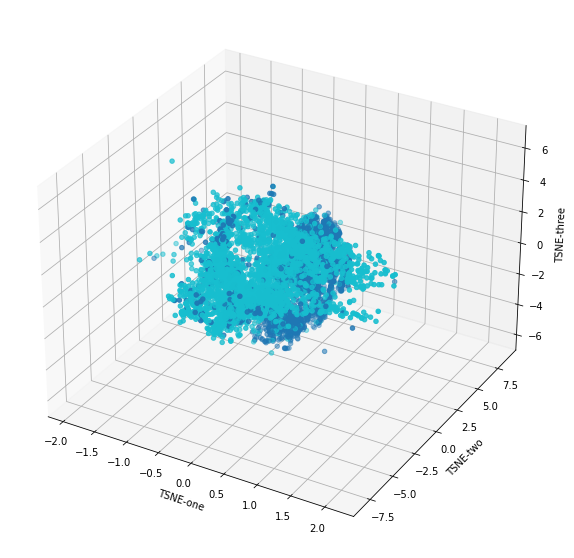

In [366]:
tsne_results.shape
new_df = pd.concat([tsne_results.reset_index(drop=True), Y_Train_Polling.reset_index(drop=True)], axis = 1)

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=new_df.loc[:]["tsne_1"], 
    ys=new_df.loc[:]["tsne_2"], 
    zs=new_df.loc[:]["tsne_3"], 
    c=new_df.loc[:]["Dem_Ind"], 
    cmap='tab10'
)
ax.set_xlabel('TSNE-one')
ax.set_ylabel('TSNE-two')
ax.set_zlabel('TSNE-three')
plt.show()

#sns.scatterplot(data = new_df, x = 'tsne_1', y = 'tsne_2', z = 'tsne_3', hue = new_df.Dem_Ind.to_list())

In [367]:
from sklearn.manifold import TSNE 
import seaborn as sns
import time 

def make_tsne(X_Data, Y_Data):
    start = time.time()
    tsne = TSNE(n_components = 2, verbose =1, perplexity =40, n_iter=300)
    tsne_results = tsne.fit_transform(X_Data)
    tsne_results = pd.DataFrame(tsne_results, columns = ['tsne_1', 'tsne_2'])
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-start))
    return tsne_results

In [368]:
tsne_results_2D = make_tsne(X_Train_Polling, Y_Train_Polling)

print(tsne_results_2D.head())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.082s...
[t-SNE] Computed neighbors for 7000 samples in 6.649s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.916052
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.771652
[t-SNE] KL divergence after 300 iterations: 3.435497
t-SNE done! Time elapsed: 16.706273078918457 seconds
     tsne_1    tsne_2
0 -8.107896  0.427607
1 -6.401823 -2.722131
2  4.885857  1.290234
3 -2.974097  1.266280
4  5.469666 -1.260339


     tsne_1    tsne_2  Dem_Ind
0 -8.107896  0.427607        1
1 -6.401823 -2.722131        1
2  4.885857  1.290234        0
3 -2.974097  1.266280        1
4  5.469666 -1.260339        0
Index(['tsne_1', 'tsne_2', 'Dem_Ind'], dtype='object')


<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

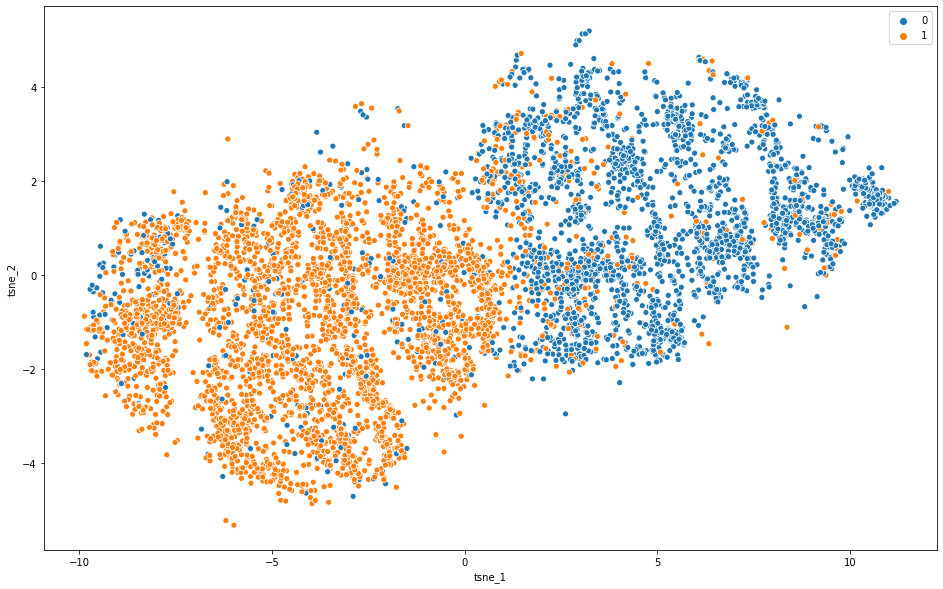

In [369]:
tsne_results_2D.shape
new_df_2D = pd.concat([tsne_results_2D.reset_index(drop=True), Y_Train_Polling.reset_index(drop=True)], axis = 1)

print(new_df_2D.head())
print(new_df_2D.columns)
plt.figure(figsize=(16,10))
sns.scatterplot(data = new_df_2D, x = 'tsne_1', y = 'tsne_2', hue = new_df_2D.Dem_Ind.to_list())


## Step 2) Apply Dimensionality Reduction Algorithms to the Datasets

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

Implement 4 Dimensionality Reduction Algorithms on the 2 Data sets
- PCA: Principal Components Analysis
- ICA: Independent Components Analysis
- RCA: Random Components Analysis 
- RFC: Random Forest Classifier

https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues

### 2.1) PCA 

In [355]:
from sklearn.decomposition import PCA 


def run_PCA(X_Data, title):
    
    pca = PCA(random_state = 42)
    pca.fit(X_Data)

    pca80 = PCA(n_components = 0.80, random_state = 42)
    pca80.fit(X_Data)
    print("Optimal Number of Components:", pca80.n_components_)
    max_feats = X_Data.shape[1]
    
    recon_error_list = []
    for i in range(2, max_feats):
        pca = PCA(n_components = i, random_state =42)
        pca.fit(X_Data)
        
        X_Trans =  pca.transform(X_Data)
        X_Proj = pca.inverse_transform(X_Trans)
        Error_Recon = metrics.mean_squared_error(X_Data, X_Proj)
        recon_error_list.append(Error_Recon)
    
    x = np.arange(1, pca.n_components_ +1)
    y1 = pca.explained_variance_ratio_.cumsum()
    y2 = pca.singular_values_
    
    # 
    fig, ax1 = plt.subplots()
    ax1.plot(x, y1, 'blue', label = 'Cumulative Explained Variance')
    ax1.plot(x, np.repeat(0.8, pca.n_components_), linestyle = '--', color = 'red')
    ax1.set_xlabel('Number of Components')
    ax1.plot([], [], 'green', label = 'Eigenvalues')
    ax1.legend()
    ax1.set_ylabel('Cumulative Explained Variance')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(x, y2, 'green')
    ax2.set_ylabel('Eigenvalues')
    plt.grid(False)
    plt.title("The Effect of Number of Components \non Explained Variance and Eigenvalues\nfor " + title + " with PCA")
    fig.tight_layout()
    plt.show()

Optimal Number of Components: 31


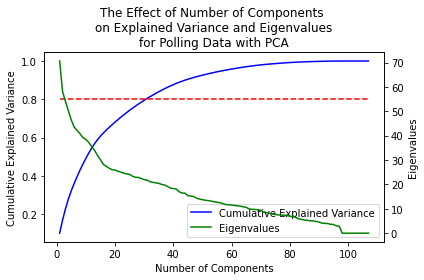

In [356]:
run_PCA(X_Train_Polling, "Polling Data")

Data #1
- Optimal Number of Components is 31

Optimal Number of Components: 19


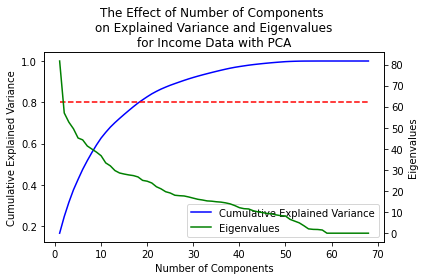

3.8245761394500732


In [357]:
start = time.time()

run_PCA(X_Train_Income, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

Data #2
- Optimal Number of Components is 19
- Higher values of Eigenvalues is better, where n_components is 2 

In [135]:
def compare_recon_error(X_Data, title):

    max_feats = X_Data.shape[1]

    pca_recon_error_list = []
    ica_recon_error_list = []
    rca_recon_error_list = []
    pca_time_list = []
    ica_time_list = []
    rca_time_list = []
    
    for num in range(2, max_feats):
        #print("N Components: ", num)
        start_pca = time.time()
        pca = PCA(n_components = num, random_state =42)
        pca.fit(X_Data)

        X_Trans =  pca.transform(X_Data)
        X_Proj = pca.inverse_transform(X_Trans)
        Error_Recon = metrics.mean_squared_error(X_Data, X_Proj)
        pca_recon_error_list.append(Error_Recon)
        #print("PCA:", Error_Recon)
        end_pca = time.time()
        pca_time_list.append(end_pca-start_pca)
        
        start_ica = time.time()
        ica = ICA(random_state=42)
        ica.set_params(n_components=num)
        X_Transformed = ica.fit_transform(X_Data)
        X_Proj = ica.inverse_transform(X_Transformed)
        Error_Recon = metrics.mean_squared_error(X_Data, X_Proj)
        ica_recon_error_list.append(Error_Recon)
        #print("ICA:", Error_Recon)
        end_ica = time.time()
        ica_time_list.append(end_ica-start_ica)
        
        start_rca = time.time()
        rca = GRP(n_components=num, random_state = 42)
        X_Reduced = rca.fit_transform(X_Data)
        psuedo_inverse = np.linalg.pinv(rca.components_.T)
        X_Reconstructed = X_Reduced.dot(psuedo_inverse)
        Error_Recon = metrics.mean_squared_error(X_Data, X_Reconstructed)
        rca_recon_error_list.append(Error_Recon)
        #print("RCA:", Error_Recon)
        end_rca = time.time()
        rca_time_list.append(end_rca-start_rca)
        
    plt.clf()
    plt.plot(pca_recon_error_list, label = "PCA")
    plt.plot(ica_recon_error_list, label = "ICA")
    plt.plot(rca_recon_error_list, label = "RCA")
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Error")
    plt.title("Comparing The Effect of Number of Components \non Reconstruction Error for \n PCA, ICA, RCA with " + title)
    plt.legend()
    plt.show()
    
    plt.clf()
    plt.plot(pca_time_list, label = "PCA")
    plt.plot(ica_time_list, label = "ICA")
    plt.plot(rca_time_list, label = "RCA")
    plt.xlabel("Number of Components")
    plt.ylabel("Time (Sec)")
    plt.title("Comparing The Effect of Number of Components \non RunTime for \n PCA, ICA, RCA with " + title)
    plt.legend()
    plt.show()
    
    print("PCA last Error:",pca_recon_error_list[-1])
    print("ICA last Error:",ica_recon_error_list[-1])
    print("RCA last Error:",rca_recon_error_list[-1])
    
    print("PCA max time:",pca_time_list[-1])
    print("ICA max time:",ica_time_list[-1])
    print("RCA max time:",rca_time_list[-1])
    
    
    

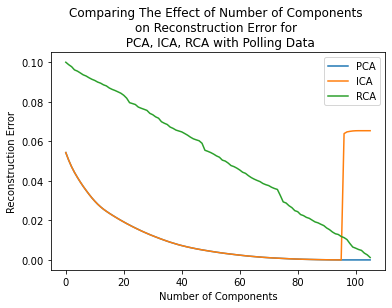

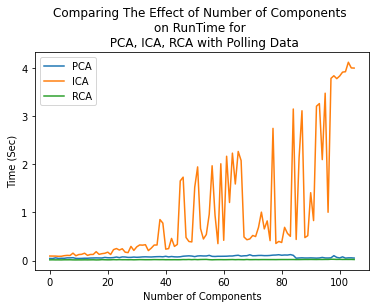

PCA last Error: 1.4706450527861673e-31
ICA last Error: 0.06537644822373492
RCA last Error: 0.0012169113998689205
PCA max time: 0.05147290229797363
ICA max time: 4.001594066619873
RCA max time: 0.020694971084594727


In [136]:
compare_recon_error(X_Train_Polling, "Polling Data")

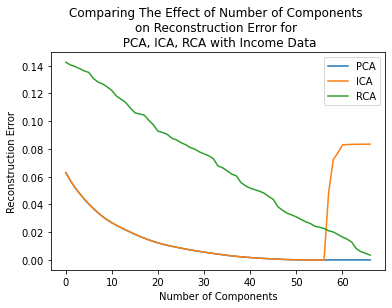

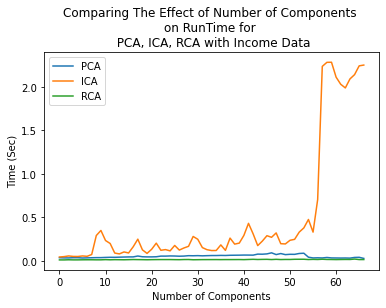

PCA last Error: 2.2762409339270582e-31
ICA last Error: 0.08348044306418168
RCA last Error: 0.0034416342264458246
PCA max time: 0.026678085327148438
ICA max time: 2.2509520053863525
RCA max time: 0.013432025909423828


In [137]:
compare_recon_error(X_Train_Income, "Income Data")

### 2.2) ICA

In [82]:
from sklearn.decomposition import FastICA as ICA 

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

def run_ICA(X_Data, title):
    
    max_feats = X_Data.shape[1]
    
    n_components_list = np.arange(2, max_feats, 1)
    
    ica = ICA(random_state=42)
    kurtosis_list = []
    recon_error_list = []

    for num in n_components_list:
        ica.set_params(n_components=num)
        X_Transformed = ica.fit_transform(X_Data)
        X_Transformed_df = pd.DataFrame(X_Transformed)
        # Find the Kurtosis Over Requested Acxis, where 0 means find Kurtosis over rows 
        X_Transformed_Kurtosis = X_Transformed_df.kurt(axis=0) # Returns Series 
        avg_kurtosis = X_Transformed_Kurtosis.abs().mean()
        kurtosis_list.append(avg_kurtosis)
        
        X_Proj = ica.inverse_transform(X_Transformed)
        Error_Recon = metrics.mean_squared_error(X_Data, X_Proj)
        recon_error_list.append(Error_Recon)
        
        print("N components:",num)
        print("Kurtosis:", avg_kurtosis)
        print("Recon error:", Error_Recon)
       
    #
    plt.clf()
    plt.plot(recon_error_list)
    plt.xlabel("Number of Components")
    plt.show()
    
    maxElement = np.amax(kurtosis_list)
    result = np.where(kurtosis_list == np.amax(kurtosis_list))
    print("Max Value:",maxElement)
    print("N Components:",result[0][0] +2)
    
    plt.figure()
    plt.title("The Effect of the Indepdent Components \non The Average Kurtosis \nfor "+ title)
    plt.xlabel("Number of Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(n_components_list, kurtosis_list)
    plt.grid(False)
    plt.show()
    
    # 
    fig, ax1 = plt.subplots()
    ax1.plot(n_components_list, kurtosis_list, 'blue', label = 'Kurtosis')
    ax1.set_xlabel('Number of Components')
    ax1.plot([], [], 'green', label = 'Reconstruction Error')
    ax1.legend()
    ax1.set_ylabel('Kurtosis')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(n_components_list, recon_error_list, 'green')
    ax2.set_ylabel('Reconstruction Error')
    plt.grid(False)
    plt.title("The Effect of Number of Components \non Kurtosis and Reconstruction Error\nfor " + title + " with ICA")
    fig.tight_layout()
    plt.show()
    
    

N components: 2
Kurtosis: 1.131709511472693
Recon error: 0.054317694943711456
N components: 3
Kurtosis: 1.2547155182090055
Recon error: 0.050453396339340366
N components: 4
Kurtosis: 1.2275060076570872
Recon error: 0.047124586712663
N components: 5
Kurtosis: 1.3172585392254257
Recon error: 0.04427630790328286
N components: 6
Kurtosis: 1.2139412570176151
Recon error: 0.041772850648094245
N components: 7
Kurtosis: 1.2021009447346311
Recon error: 0.03942207436285466
N components: 8
Kurtosis: 1.2576556973485638
Recon error: 0.03722381519888906
N components: 9
Kurtosis: 1.2243427852312512
Recon error: 0.035193239050967814
N components: 10
Kurtosis: 1.235041043470498
Recon error: 0.033236628702371734
N components: 11
Kurtosis: 1.2594495065390066
Recon error: 0.0314020168860219
N components: 12
Kurtosis: 1.2604807076389686
Recon error: 0.02972851399163817
N components: 13
Kurtosis: 1.3505790958495951
Recon error: 0.028203446716442666
N components: 14
Kurtosis: 1.401025370273739
Recon error: 0

N components: 106
Kurtosis: 69.43767385803189
Recon error: 0.06537644822373492
N components: 107
Kurtosis: 67.06691592491667
Recon error: 0.06537644822373492


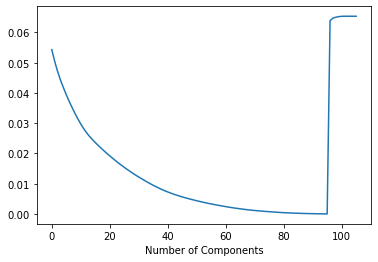

Max Value: 94.94879791206175
N Components: 98


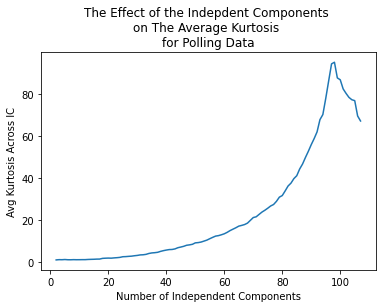

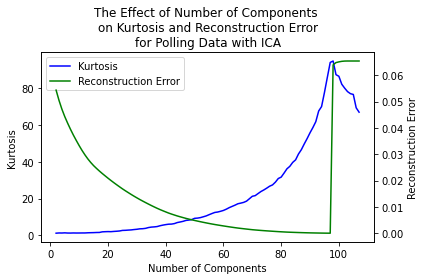

111.20642828941345


In [83]:
start = time.time()

run_ICA(X_Train_Polling, "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

PICK N = 97 for low error and high Kurtosis 

- N components: 97
- Kurtosis: 94.17773130302514
- Recon error: 4.858697723345357e-31
- N components: 98
- Kurtosis: 94.94879791206175
- Recon error: 0.06391708974998132

- When number of IC components = 30, that is when Kurtosis > 3
- Kurtosis = 3 when a distribution is Normally Distributed
- Kurtosis >> 3 implies that there is a lot of weight in the tails of a distribution, measures many outliers
- ICA did not converge, even with 2000 max iterations, but values did not change by increasing 
- We want the highest absolute value of Kurtosis, this implies the most Non-Gaussian

N components: 2
Kurtosis: 0.8101149071454676
Recon error: 0.0629465785051288
N components: 3
Kurtosis: 1.2238968784507718
Recon error: 0.057206247626632206
N components: 4
Kurtosis: 1.1836139718774663
Recon error: 0.052129579225810775
N components: 5
Kurtosis: 1.1853864281489916
Recon error: 0.04791193234510191
N components: 6
Kurtosis: 1.074620730640124
Recon error: 0.043855961749134025
N components: 7
Kurtosis: 1.1974117932963073
Recon error: 0.040314492580241716
N components: 8
Kurtosis: 1.3316357883983336
Recon error: 0.03702096590610343
N components: 9
Kurtosis: 1.229118255214117
Recon error: 0.03396261672107488
N components: 10
Kurtosis: 1.1731913545482582
Recon error: 0.031169889765369007
N components: 11
Kurtosis: 1.5030991859542049
Recon error: 0.02886940976813228
N components: 12
Kurtosis: 1.6770425962501212
Recon error: 0.026758190417010254
N components: 13
Kurtosis: 1.6502353793976128
Recon error: 0.02493174493328907
N components: 14
Kurtosis: 1.6141219504239088
Recon error

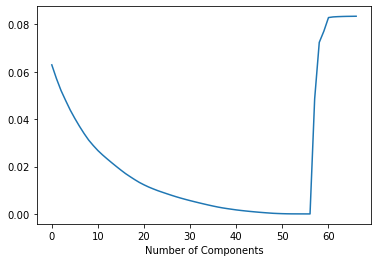

Max Value: 244.32727740295124
N Components: 61


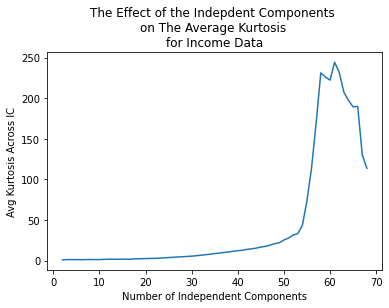

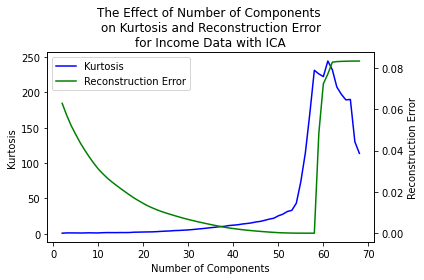

35.0909161567688


In [84]:
start = time.time()

run_ICA(X_Train_Income, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

PICK N = 58 for low Recon Error and high Kurtosis 

- N components: 58
- Kurtosis: 231.2040757032121
- Recon error: 3.36867344348749e-30
- N components: 59
- Kurtosis: 226.09335304054173
- Recon error: 0.04852882560375692
- N : 60
- Kurtosis: 222.29184308580062
- Recon error: 0.07244750864782903
- N components: 61
- Kurtosis: 244.32727740295124
- Recon error: 0.07718772839575531

- Kurtosis stays much lower in this dataset through around 55 independent components, but then it shoots up over 200 kurtosis, which is much higher than Dataset 1 
- When number of IC equals 24, the Kurtosis Exceeds a value of 3

### 2.3) RCA 

In [54]:
from sklearn.random_projection import GaussianRandomProjection as GRP

def run_RCA(X_Data, title):
    
    max_feats = X_Data.shape[1]
    n_components_list = np.arange(2, max_feats, 1)
    #n_components_list = np.arange(40, 55, 1)
    
    restarts = np.arange(1, 6, 1)
    list_of_lists = []
    
    for iteration in restarts:
        iterlist = []
        
        for num in n_components_list:

            rpa = GRP(n_components=num, random_state = iteration)

            # Fit to data using on n components 
            X_Reduced = rpa.fit_transform(X_Data)

            # Pseudo Inverse 
            psuedo_inverse = np.linalg.pinv(rpa.components_.T)
            X_Reconstructed = X_Reduced.dot(psuedo_inverse)

            Error_Recon = metrics.mean_squared_error(X_Data, X_Reconstructed)
            iterlist.append(Error_Recon)
            
        list_of_lists.append(iterlist)

    # Plot 1 
    y1 = list_of_lists[0]
    y2 = list_of_lists[1]
    y3 = list_of_lists[2]
    y4 = list_of_lists[1]
    y5 = list_of_lists[2]
    
    plt.plot(n_components_list, y1)
    plt.plot(n_components_list, y2)
    plt.plot(n_components_list, y3)
    plt.plot(n_components_list, y4)
    plt.plot(n_components_list, y5)
    
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Number of Random Components")
    plt.title("The Effect of Number of Random Components \nOn The Reconstruction Error \nfor " + title)
    plt.show()
    
    # Combine Plots Added 10.29.2020
    rca_df =  pd.DataFrame(zip(n_components_list, y1, y2, y3, y4, y5), columns = ["N Components",'Iter1', 'Iter2', 'Iter3', 'Iter4', 'Iter5'])
    
    rca_df['Mean_Error'] = rca_df.iloc[:, 1:6].mean(axis=1)
    rca_df['STD_Error'] = rca_df.iloc[:, 1:6].std(axis=1)
    
    #print(rca_df)
    
    plt.clf()
    plt.plot(n_components_list, rca_df['Mean_Error'], label = 'Mean Error')
    plt.plot(n_components_list, rca_df['STD_Error'], label = 'STD Error')
    plt.plot(n_components_list, np.repeat(0.05, len(n_components_list)), linestyle = "--", color = 'red')
    plt.legend()
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Number of Random Components")
    plt.title("The Effect of Random Components \non Mean and STD Reconstruction Error on " + title)
    plt.show()
    
    # Modify Code 
    fig, ax1 = plt.subplots()
    ax1.plot(n_components_list, rca_df['Mean_Error'], 'blue', label = 'Mean Error')
    ax1.plot(n_components_list, np.repeat(0.05, len(n_components_list)), linestyle = "--", color = 'red', label = 'Threshold')
    ax1.set_xlabel('Random Components')
    ax1.plot([], [], 'green', label = 'STD Error')
    ax1.legend()
    
    # Make the y-axis label, ticks and tick labels match the line color.
    #ax1.set_ylabel('Mean Reconstruction Error', color='blue')
    ax1.set_ylabel('Mean Reconstruction Error')
    #ax1.tick_params('y', colors='blue')
    plt.grid(False)

    ax2 = ax1.twinx()
    #ax2.plot(n_components_list, rca_df['STD_Error'], 'green', label = 'STD Error')
    ax2.plot(n_components_list, rca_df['STD_Error'], 'green')
    #ax2.set_ylabel('STD Reconstruction Error', color='green')
    #ax2.tick_params('y', colors='green')
    ax2.set_ylabel('STD Reconstruction Error')
    plt.grid(False)

    plt.title("The Effect of Random Components \non Mean and STD Reconstruction Error \nWith 5 Random Restarts on " + title)
    
    fig.tight_layout()
    plt.show()
    

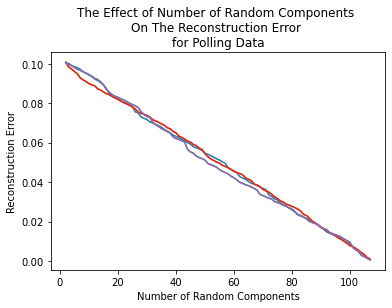

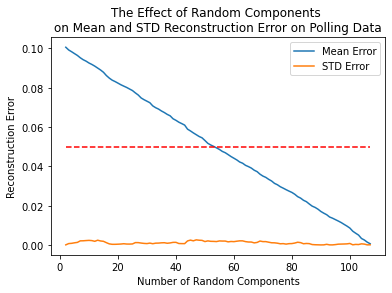

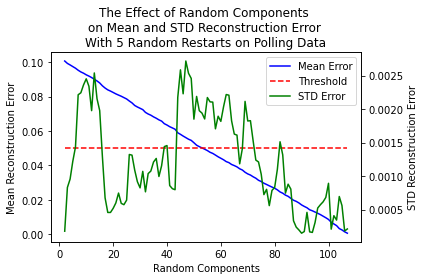

7.646842002868652


In [55]:
start = time.time()

run_RCA(X_Train_Polling, "Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

- For Data #1, Reconstruction Error is minimized with maximum number of features included
- We can reach less than 5% error rate with 54 number of components 

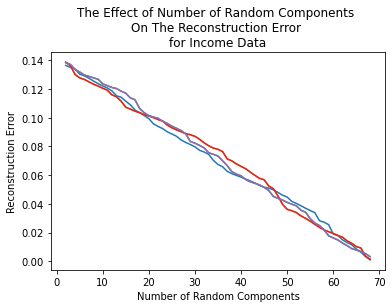

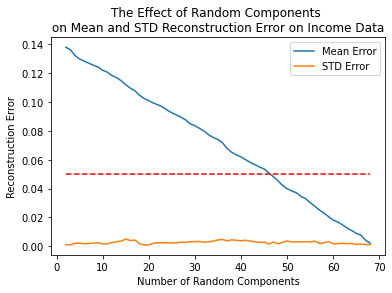

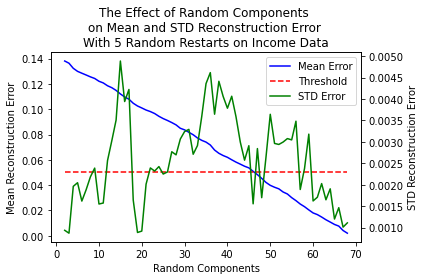

4.250942945480347


In [56]:
start = time.time()

run_RCA(X_Train_Income, "Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

- RCA, Data #2 Requires 47 components

### Step 2.4) Random Forest Classifier

We can use Y in this Dimensionality Reduction Algorithm

In [138]:
from sklearn.ensemble import RandomForestClassifier as RFC

# How many features do we need to get 95% of feature importance? 
def RFC_min_samples_leaf(X_Data, Y_Data, title):
    
    # The Data is 7000 rows long, 70 is 1% of that 
    num_samples_leaf = np.arange(1, 72, 1)
    num_components_list = []
    
    for num in num_samples_leaf:
    
        rfc = RFC(n_estimators=100, min_samples_leaf= num, random_state=42)
        importances = rfc.fit(X_Data, Y_Data).feature_importances_ 

        importances = pd.DataFrame(importances,columns=['Feature Importance'],index=X_Data.columns)
        importances.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
        importances['Cum Sum'] = importances['Feature Importance'].cumsum()
        importances = importances[importances['Cum Sum']<=0.95]
        top_cols = importances.index.tolist()

        #return (importances, top_cols)
        num_components_list.append(len(top_cols))
        
    plt.plot(num_samples_leaf, num_components_list)
    plt.xlabel("Number of Min Leaf Samples")
    plt.ylabel("Number of Components to get 95%")
    plt.title("The Effect of Min Leaf Samples Size \nOn Number of Components in Random Forest \nFor "+ title)
    plt.show()
    

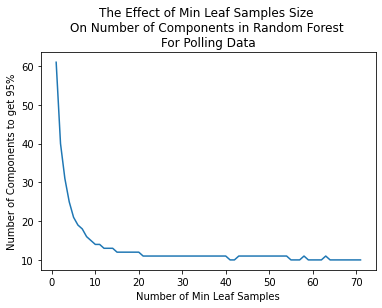

27.42136788368225


In [139]:
start = time.time()

RFC_min_samples_leaf(X_Train_Polling, Y_Train_Polling, "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

- Data # 1 should have 12 as the min_samples_leaf size

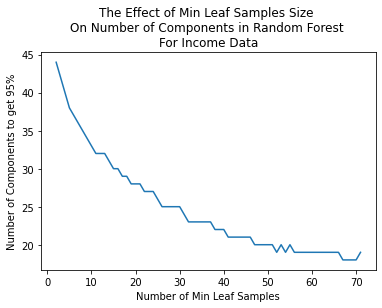

24.897008180618286


In [89]:
start = time.time()

RFC_min_samples_leaf(X_Train_Income, Y_Train_Income, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

- Data #2 should have ~47 as the min_samples_leaf size 

In [90]:
from sklearn.ensemble import RandomForestClassifier as RFC

# How many features do we need to get 95% of feature importance? 
def run_RFC(X_Data, Y_Data, min_samples):
    
    rfc = RFC(n_estimators=100, min_samples_leaf=min_samples, random_state=42)
    
    importances = rfc.fit(X_Data, Y_Data).feature_importances_ 
    
    importances = pd.DataFrame(importances,columns=['Feature Importance'],index=X_Data.columns)
    importances.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    importances['Cum Sum'] = importances['Feature Importance'].cumsum()
    importances = importances[importances['Cum Sum']<=0.95]
    top_cols = importances.index.tolist()
    
    return (importances, top_cols)

In [91]:
importances, top_cols = run_RFC(X_Train_Polling, Y_Train_Polling, 12)

print(importances.shape)

importances

(13, 2)


,Feature Importance,Cum Sum
approval_pres_Strongly Disapprove,0.397137,0.397137
approval_pres_Strongly Approve,0.187498,0.584635
economy_retro_Gotten Much Better,0.105779,0.690414
approval_pres_Approve / Somewhat Approve,0.082038,0.772452
economy_retro_Stayed About The Same,0.035982,0.808434
economy_retro_Gotten Worse / Somewhat Worse,0.031179,0.839612
economy_retro_Gotten Better / Somewhat Better,0.026024,0.865636
race_Black,0.025846,0.891483
race_White,0.018611,0.910093
approval_pres_Disapprove / Somewhat Disapprove,0.013091,0.923185


- Dataset #1 Only requires 13 features to explain 95% of the results, using Random Forest Classifer 

In [92]:
importances, top_cols  = run_RFC(X_Train_Income, Y_Train_Income, 47)

print(importances.shape)

importances

(20, 2)


,Feature Importance,Cum Sum
marital.status_Married-civ-spouse,0.222067,0.222067
relationship_Husband,0.157912,0.379979
age_band_Young,0.071949,0.451929
marital.status_Never-married,0.060349,0.512278
occupation_Exec-managerial,0.054112,0.566390
hours_band_High,0.053364,0.619754
education_Bachelors,0.043697,0.663451
occupation_Prof-specialty,0.042281,0.705732
hours_band_Low,0.031157,0.736889
sex_Female,0.026713,0.763602


- Dataset #2, only Needs 19 components to get 95% of the feature importance using Random Forest Classifier

## Step 3)

#### Step 3) Data 1 

In [140]:
pca_X_Train_Polling = PCA(n_components = 31, random_state = 42).fit_transform(X_Train_Polling)
ica_X_Train_Polling = ICA(n_components = 97, random_state = 42).fit_transform(X_Train_Polling)
rca_X_Train_Polling = GRP(n_components = 54, random_state = 42).fit_transform(X_Train_Polling)

In [141]:
top_cols_df, top_cols = run_RFC(X_Train_Polling, Y_Train_Polling, 12)
rfc_X_Train_Polling = X_Train_Polling[top_cols] 

### Step 3) Data 1 With K-Means

Step 3.1) Data 1 With K-Means with PCA 

<Figure size 432x288 with 0 Axes>

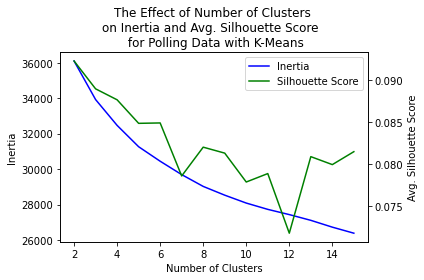

14.201623916625977


In [142]:
start = time.time()

run_kmeans(pca_X_Train_Polling, np.arange(2, 16, 1), "Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

Step 3.2) Data 1 With K-Means with ICA

<Figure size 432x288 with 0 Axes>

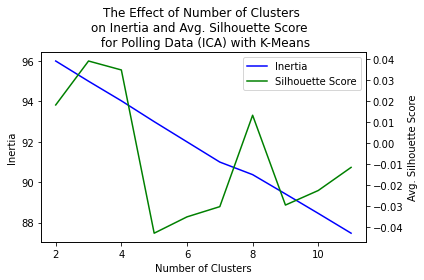

10.273818969726562


In [163]:
start = time.time()

run_kmeans(ica_X_Train_Polling, np.arange(2, 12, 1), "Polling Data (ICA)")

end = time.time()
elapsed = end - start
print(elapsed)

- ICA for Data 1, reduced dataset, shows that the optimal number of clusters may not be 2 if we are using ICA 
- Optimal Clusters is 4, combine SScore with Inertia. Need SScore > 0 

Step 3.3) Data 1 With K-Means with RCA 

<Figure size 432x288 with 0 Axes>

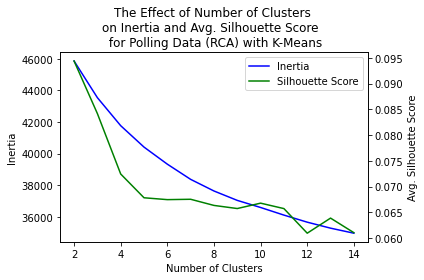

14.983834028244019


In [164]:
start = time.time()

run_kmeans(rca_X_Train_Polling, np.arange(2, 15, 1), "Polling Data (RCA)")

end = time.time()
elapsed = end - start
print(elapsed)

Step 3.4) Data 1 with K-Means and RFC 

<Figure size 432x288 with 0 Axes>

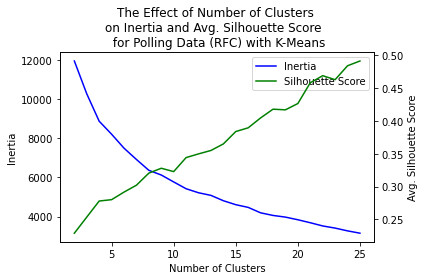

19.546549081802368


In [165]:
start = time.time()

run_kmeans(rfc_X_Train_Polling, np.arange(2, 26, 1), "Polling Data (RFC)" )

end = time.time()
elapsed = end - start
print(elapsed)

<Figure size 432x288 with 0 Axes>

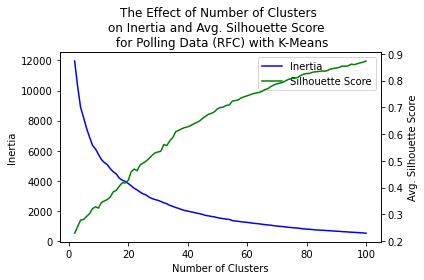

112.82123589515686


In [166]:
start = time.time()

run_kmeans(rfc_X_Train_Polling, np.arange(2, 101, 1), "Polling Data (RFC)" )

end = time.time()
elapsed = end - start
print(elapsed)

<Figure size 432x288 with 0 Axes>

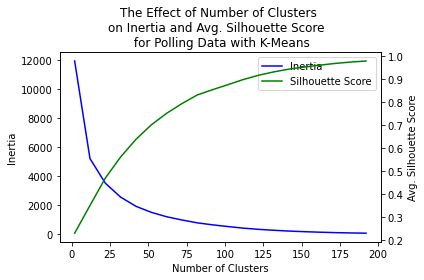

29.08548617362976


In [160]:
start = time.time()

run_kmeans(rfc_X_Train_Polling, np.arange(2, 201, 10), "Polling Data" )

end = time.time()
elapsed = end - start
print(elapsed)

### Step 3) Data 1 With EM

3.5) Data 1 With EM with PCA 

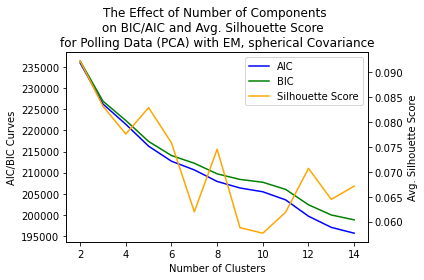

10.608741998672485


In [174]:
start = time.time()

run_em(pca_X_Train_Polling, np.arange(2, 15, 1), "Polling Data (PCA)", 'spherical')

end = time.time()
elapsed = end - start
print(elapsed)

Data 1, EM, ICA

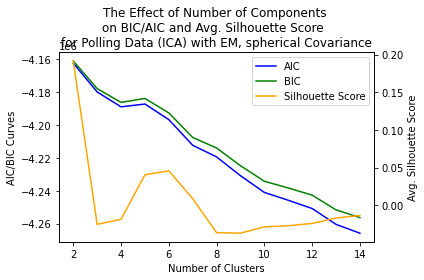

11.099154949188232


In [175]:
start = time.time()

run_em(ica_X_Train_Polling, np.arange(2, 15, 1), "Polling Data (ICA)", 'spherical')

end = time.time()
elapsed = end - start
print(elapsed)

Data 1, EM, RCA

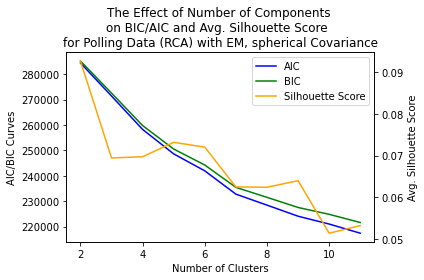

8.378161907196045


In [176]:
start = time.time()

run_em(rca_X_Train_Polling, np.arange(2, 12, 1), "Polling Data (RCA)", 'spherical')

end = time.time()
elapsed = end - start
print(elapsed)

Data 1, EM, RFC

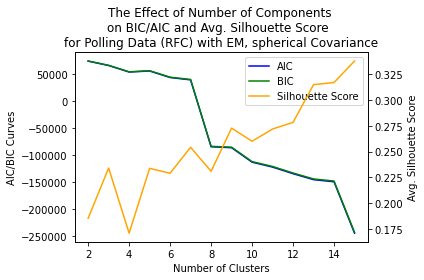

10.127234697341919


In [177]:
start = time.time()

run_em(rfc_X_Train_Polling, np.arange(2, 16, 1), "Polling Data (RFC)", 'spherical')

end = time.time()
elapsed = end - start
print(elapsed)

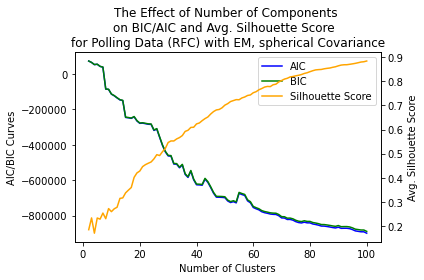

89.83065009117126


In [178]:
start = time.time()

run_em(rfc_X_Train_Polling, np.arange(2, 101, 1), "Polling Data (RFC)", 'spherical')

end = time.time()
elapsed = end - start
print(elapsed)

### Step 3) Data 2

In [150]:
pca_X_Train_Income = PCA(n_components = 19, random_state = 42).fit_transform(X_Train_Income)
ica_X_Train_Income = ICA(n_components = 58, random_state = 42).fit_transform(X_Train_Income)
rca_X_Train_Income = GRP(n_components = 47, random_state = 42).fit_transform(X_Train_Income)

top_cols_df, top_cols = run_RFC(X_Train_Income, Y_Train_Income, 47)
rfc_X_Train_Income = X_Train_Income[top_cols] 

Data 2, PCA, KMeans

<Figure size 432x288 with 0 Axes>

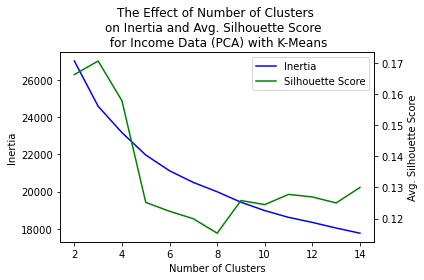

11.73264479637146


In [179]:
start = time.time()

run_kmeans(pca_X_Train_Income, np.arange(2, 15, 1), "Income Data (PCA)")

end = time.time()
elapsed = end - start
print(elapsed)

<Figure size 432x288 with 0 Axes>

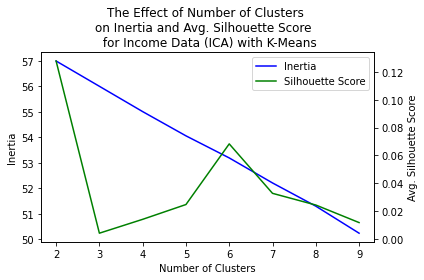

7.516122817993164


In [180]:
start = time.time()

run_kmeans(ica_X_Train_Income, np.arange(2, 10, 1), "Income Data (ICA)")

end = time.time()
elapsed = end - start
print(elapsed)

<Figure size 432x288 with 0 Axes>

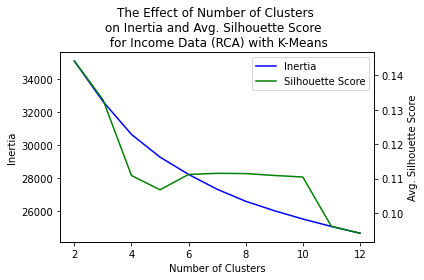

11.081938743591309


In [181]:
start = time.time()

run_kmeans(rca_X_Train_Income, np.arange(2, 13, 1), "Income Data (RCA)")

end = time.time()
elapsed = end - start
print(elapsed)

<Figure size 432x288 with 0 Axes>

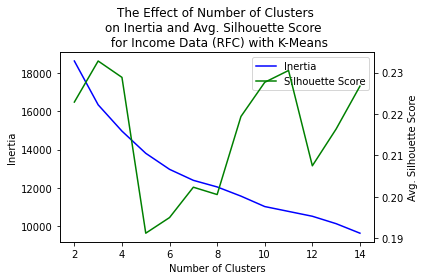

11.12702226638794


In [182]:
start = time.time()

run_kmeans(rfc_X_Train_Income, np.arange(2, 15, 1), "Income Data (RFC)")

end = time.time()
elapsed = end - start
print(elapsed)

<Figure size 432x288 with 0 Axes>

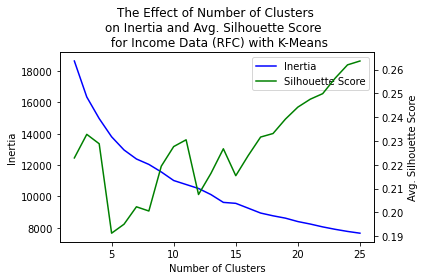

20.748114109039307


In [188]:
start = time.time()

run_kmeans(rfc_X_Train_Income, np.arange(2, 26, 1), "Income Data (RFC)")

end = time.time()
elapsed = end - start
print(elapsed)

<Figure size 432x288 with 0 Axes>

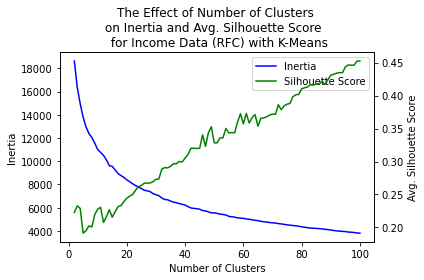

129.63932704925537


In [187]:
start = time.time()

run_kmeans(rfc_X_Train_Income, np.arange(2, 101, 1), "Income Data (RFC)")

end = time.time()
elapsed = end - start
print(elapsed)

Data 2 on EM

PCA

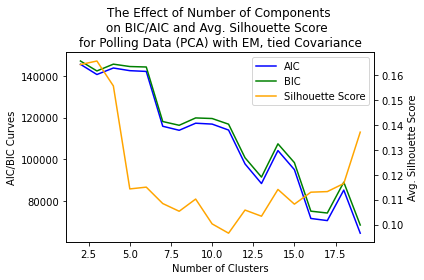

17.051665782928467


In [193]:
start = time.time()

run_em(pca_X_Train_Income, np.arange(2, 20, 1), "Polling Data (PCA)", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

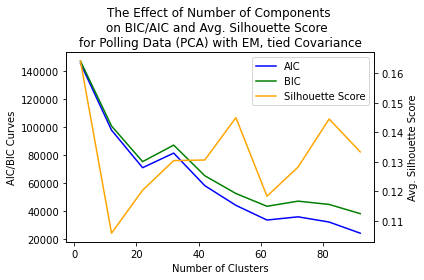

20.453273057937622


In [194]:
start = time.time()

run_em(pca_X_Train_Income, np.arange(2, 102, 10), "Polling Data (PCA)", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

ICA

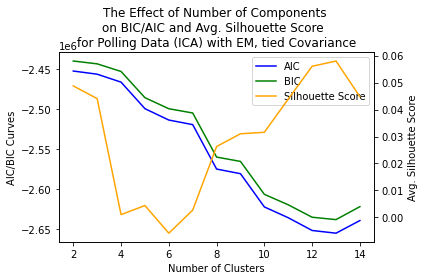

11.734766721725464


In [195]:
start = time.time()

run_em(ica_X_Train_Income, np.arange(2, 15, 1), "Polling Data (ICA)", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

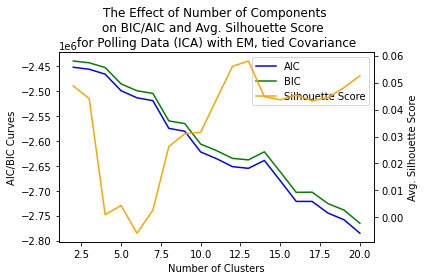

19.339548349380493


In [199]:
start = time.time()

run_em(ica_X_Train_Income, np.arange(2, 21, 1), "Polling Data (ICA)", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

RCA

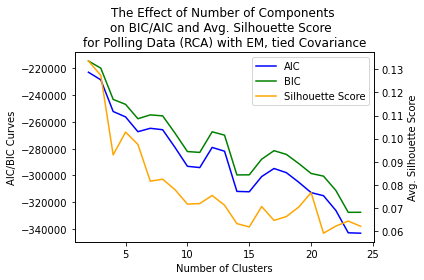

27.029469966888428


In [196]:
start = time.time()

run_em(rca_X_Train_Income, np.arange(2, 25, 1), "Polling Data (RCA)", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

RFC

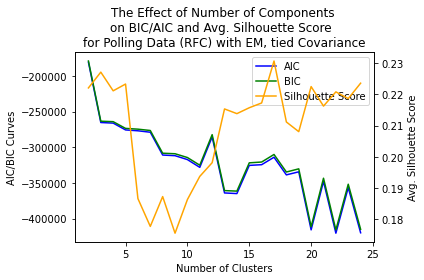

18.829216957092285


In [197]:
start = time.time()

run_em(rfc_X_Train_Income, np.arange(2, 25, 1), "Polling Data (RFC)", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

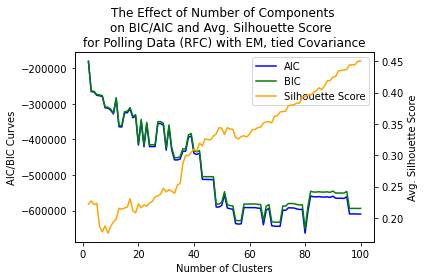

374.26901507377625


In [198]:
start = time.time()

run_em(rfc_X_Train_Income, np.arange(2, 101, 1), "Polling Data (RFC)", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

### Step 4: Use the Dimensionalty Reduced Datasets, Run Neural Networks 

In [200]:
pca_X_Train_Polling.shape

(7000, 31)

In [241]:
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import confusion_matrix

def make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, hidden_layer_sizes, activation, solver, LR_init):
    
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(pca_X_Train_Polling, Y_Train_Polling, test_size=0.30, random_state=42)


    classifier = MLPClassifier(random_state=42,
                                       learning_rate_init = LR_init, 
                                       hidden_layer_sizes = (hidden_layer_sizes,),
                                       activation = activation, solver=solver, max_iter=200)

    classifier.fit(X_Train, Y_Train)


    Y_Pred = classifier.predict(X_Test)
    cm = confusion_matrix(Y_Test, Y_Pred)
    tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
    f1_score = (2*tp) / (2*tp + fp + fn)
    return(f1_score)
    #f1_scores_test.append(f1_score)

    #Y_Pred = classifier.predict(X_Train)
    #cm = confusion_matrix(Y_Train, Y_Pred)
    #tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
    #f1_score = (2*tp) / (2*tp + fp + fn)
    #print(f1_score)
    #f1_scores_train.append(f1_score)


Data #1

#### Activation Function

PCA

In [242]:
activation_functions = ['identity', 'tanh', 'relu', 'logistic' ]

for activation in activation_functions:
    print("F1 Score:", make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 156, activation, 'adam', 0.01), \
         "Activation: ", activation)


F1 Score: 0.9234527687296417 Activation:  identity
F1 Score: 0.8965238480194018 Activation:  tanh
F1 Score: 0.8981891348088531 Activation:  relu
F1 Score: 0.9037690457097033 Activation:  logistic


ICA

In [203]:
activation_functions = ['identity', 'tanh', 'relu', 'logistic' ]

for activation in activation_functions:
    print("F1 Score:", make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 156, activation, 'adam', 0.01), \
         "Activation: ", activation)


F1 Score: 0.9245663574021783 Activation:  identity
F1 Score: 0.9245663574021783 Activation:  tanh
F1 Score: 0.9063761097659403 Activation:  relu
F1 Score: 0.9230769230769231 Activation:  logistic


RCA

In [204]:
activation_functions = ['identity', 'tanh', 'relu', 'logistic' ]

for activation in activation_functions:
    print("F1 Score:", make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 156, activation, 'adam', 0.01), \
         "Activation: ", activation)


F1 Score: 0.9209225700164745 Activation:  identity
F1 Score: 0.8938231731933791 Activation:  tanh
F1 Score: 0.899119295436349 Activation:  relu
F1 Score: 0.8993558776167472 Activation:  logistic


RFC

In [205]:
activation_functions = ['identity', 'tanh', 'relu', 'logistic' ]

for activation in activation_functions:
    print("F1 Score:", make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 156, activation, 'adam', 0.01), \
         "Activation: ", activation)


F1 Score: 0.9235104669887279 Activation:  identity
F1 Score: 0.9246963562753037 Activation:  tanh
F1 Score: 0.9210950080515298 Activation:  relu
F1 Score: 0.9243765084473049 Activation:  logistic


In [206]:
print("PCA:", make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 156, 'identity', 'adam', 0.01))
print("ICA:", make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 156, 'tanh', 'adam', 0.01))
print("RCA:", make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 156, 'identity', 'adam', 0.01))
print("RFC:", make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 156, 'tanh', 'adam', 0.01))

PCA: 0.9234527687296417
ICA: 0.9245663574021783
RCA: 0.9209225700164745
RFC: 0.9246963562753037


#### Hidden Layer Sizes

PCA

[0.925264012997563, 0.9245663574021783, 0.921760391198044, 0.9236980218005651, 0.9225780299959465, 0.9243833400727861, 0.9248788368336026, 0.9248181083265966, 0.9245663574021783, 0.9224522939504669, 0.9220146222583265, 0.9253128784820347, 0.9248181083265966, 0.9224522939504669, 0.9225152129817444, 0.9216402760860739]


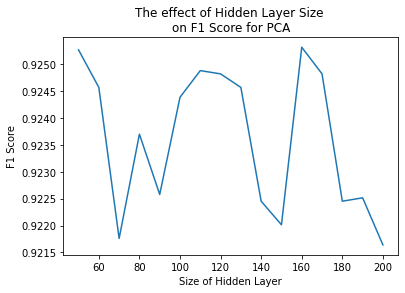

In [210]:
f1_score_list = []
hidden_layers_list = np.arange(50, 201, 10)

for HL in hidden_layers_list:
    f1_score = make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, HL, 'identity', 'adam', 0.01)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(hidden_layers_list, f1_score_list)
plt.xlabel("Size of Hidden Layer")
plt.ylabel("F1 Score")
plt.title("The effect of Hidden Layer Size \non F1 Score for PCA")
plt.show()   

ICA

[0.9241994325091204, 0.9238210399032648, 0.9238210399032648, 0.9255189255189256, 0.9230145867098866, 0.9230152365677626, 0.9243902439024391, 0.9257465698143664, 0.9228925289652418, 0.9238249594813615, 0.9247661651077674, 0.9225806451612903, 0.9233265720081136, 0.9235173824130879, 0.9223340040241449, 0.9219183511692429]


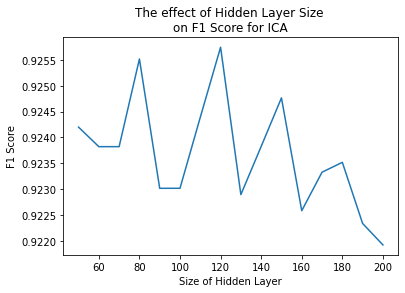

In [209]:
f1_score_list = []
hidden_layers_list = np.arange(50, 201, 10)

for HL in hidden_layers_list:
    f1_score = make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, HL, 'tanh', 'adam', 0.01)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(hidden_layers_list, f1_score_list)
plt.xlabel("Size of Hidden Layer")
plt.ylabel("F1 Score")
plt.title("The effect of Hidden Layer Size \non F1 Score for ICA")
plt.show()   

RCA

[0.9219571370804691, 0.9222042139384117, 0.9210950080515298, 0.9230145867098866, 0.9229534510433387, 0.9239482200647249, 0.9227625664078464, 0.9220831651190957, 0.9240146281999188, 0.9218813905930471, 0.9227033589639821, 0.9231398201144726, 0.9240097008892482, 0.9222042139384117, 0.9225700164744646, 0.922077922077922]


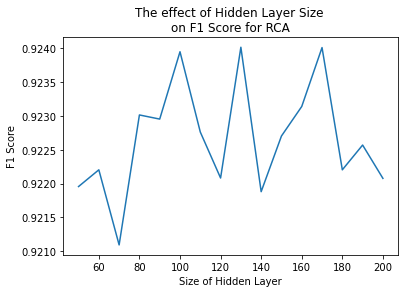

In [211]:
f1_score_list = []
hidden_layers_list = np.arange(50, 201, 10)

for HL in hidden_layers_list:
    f1_score = make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, HL, 'identity', 'adam', 0.01)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(hidden_layers_list, f1_score_list)
plt.xlabel("Size of Hidden Layer")
plt.ylabel("F1 Score")
plt.title("The effect of Hidden Layer Size \non F1 Score for RCA")
plt.show()   

RFC

[0.9230769230769231, 0.924322136786726, 0.9233870967741935, 0.9245054501412999, 0.9229528035498185, 0.9220146222583265, 0.9217038539553752, 0.9227033589639821, 0.9217741935483871, 0.9241268566840626, 0.9228295819935691, 0.9238249594813615, 0.9251920744035584, 0.9250708788983394, 0.9245054501412999, 0.9200162403572879]


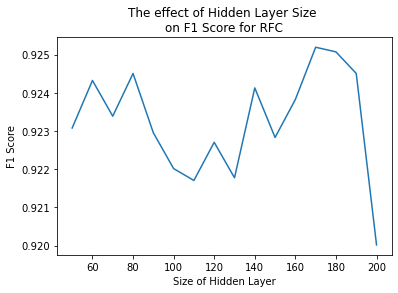

In [212]:
f1_score_list = []
hidden_layers_list = np.arange(50, 201, 10)

for HL in hidden_layers_list:
    f1_score = make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, HL, 'tanh', 'adam', 0.01)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(hidden_layers_list, f1_score_list)
plt.xlabel("Size of Hidden Layer")
plt.ylabel("F1 Score")
plt.title("The effect of Hidden Layer Size \non F1 Score for RFC")
plt.show()   

#### Best So far

In [232]:
print("PCA:", make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 160, 'identity', 'adam', 0.01))
print("ICA:", make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 120, 'tanh', 'adam', 0.01))
print("RCA:", make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 170, 'identity', 'adam', 0.01))
print("RFC:", make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 170, 'tanh', 'adam', 0.01))

PCA: 0.9253128784820347
ICA: 0.9257465698143664
RCA: 0.9240097008892482
RFC: 0.9251920744035584


#### Initial Learning Rate

PCA

[0.9230145867098866, 0.9225780299959465, 0.9253128784820347, 0.9225806451612903, 0.9173116089613035, 0.8942457231726283]


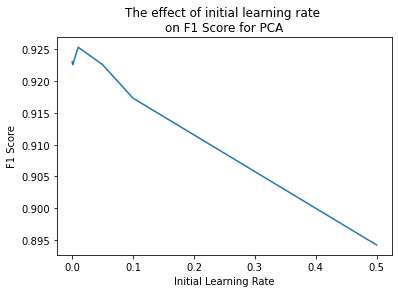

In [214]:
f1_score_list = []
init_LR_list = [0.0001, 0.001, 0.01, 0.05, 0.10, 0.50]

for LR in init_LR_list:
    f1_score = make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 160, 'identity', 'adam', LR)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(init_LR_list, f1_score_list)
plt.xlabel("Initial Learning Rate")
plt.ylabel("F1 Score")
plt.title("The effect of initial learning rate \non F1 Score for PCA")
plt.show()   

ICA

[0.8836846213895394, 0.9227033589639821, 0.9257465698143664, 0.9260450160771704, 0.9225181598062954, 0.8851913477537438]


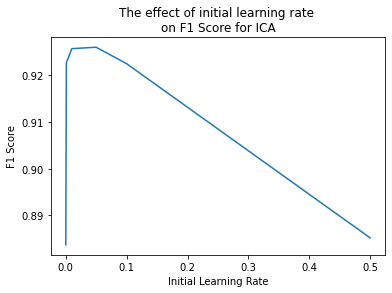

In [215]:
f1_score_list = []
init_LR_list = [0.0001, 0.001, 0.01, 0.05, 0.10, 0.50]

for LR in init_LR_list:
    f1_score = make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 120, 'tanh', 'adam', LR)
    f1_score_list.append(f1_score)

print(f1_score_list)
 
plt.clf()
plt.plot(init_LR_list, f1_score_list)
plt.xlabel("Initial Learning Rate")
plt.ylabel("F1 Score")
plt.title("The effect of initial learning rate \non F1 Score for ICA")
plt.show()   

RCA

[0.9248273059731816, 0.9233887312525334, 0.9240097008892482, 0.9233305853256389, 0.9125816993464052, 0.9182941410920685]


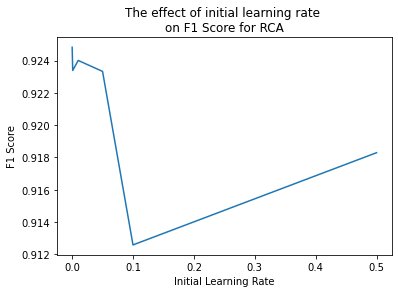

In [216]:
f1_score_list = []
init_LR_list = [0.0001, 0.001, 0.01, 0.05, 0.10, 0.50]

for LR in init_LR_list:
    f1_score = make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 170, 'identity', 'adam', LR)
    f1_score_list.append(f1_score)
    
print(f1_score_list)

plt.clf()
plt.plot(init_LR_list, f1_score_list)
plt.xlabel("Initial Learning Rate")
plt.ylabel("F1 Score")
plt.title("The effect of initial learning rate \non F1 Score for RCA")
plt.show()   

RFC

[0.9223261488409923, 0.9232643118148599, 0.9251920744035584, 0.9249899719213799, 0.9224, 0.6806943713834824]


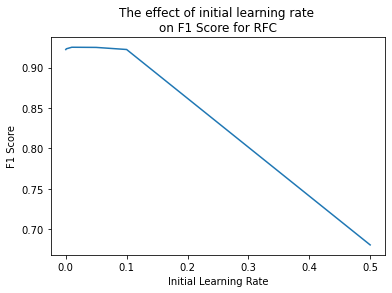

In [217]:
f1_score_list = []
init_LR_list = [0.0001, 0.001, 0.01, 0.05, 0.10, 0.50]

for LR in init_LR_list:
    f1_score = make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 170, 'tanh', 'adam', LR)
    f1_score_list.append(f1_score)

print(f1_score_list)
 
plt.clf()
plt.plot(init_LR_list, f1_score_list)
plt.xlabel("Initial Learning Rate")
plt.ylabel("F1 Score")
plt.title("The effect of initial learning rate \non F1 Score for RFC")
plt.show()   

#### Best Results

In [218]:
print("Full:", make_ann_dimred(X_Train_Polling, Y_Train_Polling, 156, 'identity', 'adam', 0.01))

Full: 0.9223300970873787


In [219]:
print("PCA:", make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 160, 'identity', 'adam', 0.01))
print("ICA:", make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 120, 'tanh', 'adam', 0.05))
print("RCA:", make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 170, 'identity', 'adam', 0.0001))
print("RFC:", make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 170, 'tanh', 'adam', 0.01))

PCA: 0.9253128784820347
ICA: 0.9260450160771704
RCA: 0.9248273059731816
RFC: 0.9251920744035584


In [238]:
start = time.time()
full = make_ann_dimred(X_Train_Polling, Y_Train_Polling, 156, 'identity', 'adam', 0.01)
end = time.time()
print("Full Score:", full, "Time", end-start)

start = time.time()
pca = make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 160, 'identity', 'adam', 0.01)
end = time.time()
print("PCA Score:", pca,"Time:", end-start)

start = time.time()
ica = make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 120, 'tanh', 'adam', 0.05)
end = time.time()
print("ICA Score:", ica, "Time:" ,end-start)

start = time.time()
rca = make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 170, 'identity', 'adam', 0.0001)
end = time.time()
print("RCA Score:", rca, "Time:", end-start)

start = time.time()
rfc = make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 170, 'tanh', 'adam', 0.01)
end = time.time()
print("RFC Score:", rfc, "Time:", end-start)

Full Score: 0.9223300970873787 Time 0.7421789169311523
PCA Score: 0.9253128784820347 Time: 0.3968789577484131
ICA Score: 0.9260450160771704 Time: 0.4926900863647461
RCA Score: 0.9248273059731816 Time: 2.600872278213501
RFC Score: 0.9251920744035584 Time: 1.2743101119995117



### Step 5: Apply Clustering Algorithms, then use those labels to feed into a Neural Network

Make one Prediction for KM, and one for EM

Full Dataset with ANN - Baseline

In [253]:
def make_ann(X_Data, Y_Data):
    
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Data, Y_Data, test_size = .30, train_size = .70, random_state = 42)

    classifier = MLPClassifier(random_state=42,
                                       learning_rate_init = 0.01, 
                                       hidden_layer_sizes = (156,),
                                       activation = 'identity', solver='adam', max_iter=2000)
    classifier.fit(X_Train, Y_Train)
    print("Shape:",X_Train.shape)
    Y_Pred = classifier.predict(X_Test)
    cm = confusion_matrix(Y_Test, Y_Pred)
    tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
    f1_score = (2*tp) / (2*tp + fp + fn)
    print("F1 Score:",f1_score)

In [254]:
start = time.time()

make_ann(X_Train_Polling, Y_Train_Polling)

end = time.time()
elapsed = end-start
print("Runtime:",elapsed)

Shape: (4900, 108)
F1 Score: 0.9223300970873787
Runtime: 0.8616769313812256


KMeans

In [255]:
def make_ann_kmeans(X_Data, Y_Data, KM_Clusters):

    #kmeans =  KMeans(n_clusters = 10, init = 'k-means++', n_init = 10, random_state = 42)
    kmeans =  KMeans(n_clusters = 2, init = 'k-means++', n_init = 10, random_state = 42)
    kmeans_labels = kmeans.fit_predict(X_Data)

    kmeans_labels = pd.DataFrame(kmeans_labels, columns = ['KM'])

    # Add the NN Labels Here:
    X_Train, X_Test, Y_Train, Y_Test = prep_data(kmeans_labels, Y_Data, ['KM'])

    classifier = MLPClassifier(random_state=42,
                                       learning_rate_init = 0.01, 
                                       hidden_layer_sizes = (156,),
                                       activation = 'identity', solver='adam', max_iter=2000)
    classifier.fit(X_Train, Y_Train)
    print("Shape:",X_Train.shape)
    Y_Pred = classifier.predict(X_Test)
    cm = confusion_matrix(Y_Test, Y_Pred)
    tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
    f1_score = (2*tp) / (2*tp + fp + fn)
    print("F1 Score:",f1_score)

In [256]:
start = time.time()

make_ann_kmeans(X_Train_Polling, Y_Train_Polling, 10)

end = time.time()
elapsed = end-start
print("Runtime:",elapsed)

Shape: (4900, 2)
F1 Score: 0.6446740858505564
Runtime: 0.47906994819641113


EM

In [257]:
def make_ann_em(X_Data, Y_Data, EM_Clusters):
  
    #em = EM(n_components = 8, covariance_type = 'spherical', n_init = 1, init_params = 'kmeans', random_state = 42)
    em = EM(n_components = 5, covariance_type = 'spherical', n_init = 1, init_params = 'kmeans', random_state = 42)
    em_labels = em.fit_predict(X_Data)

    em_labels = pd.DataFrame(em_labels, columns = ['EM'])

    # Add the NN Labels Here:
    X_Train, X_Test, Y_Train, Y_Test = prep_data(em_labels, Y_Data, ['EM'])

    classifier = MLPClassifier(random_state=42,
                                       learning_rate_init = 0.01, 
                                       hidden_layer_sizes = (156,),
                                       activation = 'identity', solver='adam', max_iter=200)
    classifier.fit(X_Train, Y_Train)
    print("Shape:",X_Train.shape)
    Y_Pred = classifier.predict(X_Test)
    cm = confusion_matrix(Y_Test, Y_Pred)
    tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
    f1_score = (2*tp) / (2*tp + fp + fn)
    print("F1 Score:",f1_score)

In [258]:
start = time.time()

make_ann_em(X_Train_Polling, Y_Train_Polling, 8)

end = time.time()
elapsed = end-start
print("Runtime:",elapsed)

Shape: (4900, 5)
F1 Score: 0.876001526135063
Runtime: 0.492236852645874


Add KM and EM Cluster Labels to the Original Dataset: an Augmentation

#### KMeans Augmented

In [259]:
def make_ann_kmeans_augment(X_Data, Y_Data):
    
    #kmeans =  KMeans(n_clusters = 10, init = 'k-means++', n_init = 10, random_state = 42)
    kmeans =  KMeans(n_clusters = 2, init = 'k-means++', n_init = 10, random_state = 42)
    kmeans_labels = kmeans.fit_predict(X_Data)

    kmeans_labels = pd.DataFrame(kmeans_labels, columns = ['KM'])

    # Must RESET INDEX 
    X_New = pd.concat([X_Data.reset_index(drop=True), kmeans_labels.reset_index(drop=True)], axis=1)

    # Add the NN Labels Here:
    X_Train, X_Test, Y_Train, Y_Test = prep_data(X_New, Y_Data, ['KM'])

    classifier = MLPClassifier(random_state=42,
                                       learning_rate_init = 0.01, 
                                       hidden_layer_sizes = (156,),
                                       activation = 'identity', solver='adam', max_iter=2000)
    classifier.fit(X_Train, Y_Train)
    
    print("Shape:", X_Train.shape)
    
    Y_Pred = classifier.predict(X_Test)
    cm = confusion_matrix(Y_Test, Y_Pred)
    tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
    f1_score = (2*tp) / (2*tp + fp + fn)
    print("F1 Score:", f1_score)

In [260]:
start = time.time()

make_ann_kmeans_augment(X_Train_Polling, Y_Train_Polling)

end = time.time()
elapsed = end-start
print("Runtime:",elapsed)

Shape: (4900, 110)
F1 Score: 0.9232019504266559
Runtime: 0.8567469120025635


#### EM Augmented

In [261]:
def make_ann_em_augment(X_Data, Y_Data):
    
    #em = EM(n_components = 8, covariance_type = 'spherical', n_init = 1, init_params = 'kmeans', random_state = 42)
    em = EM(n_components = 5, covariance_type = 'spherical', n_init = 1, init_params = 'kmeans', random_state = 42)
    em_labels = em.fit_predict(X_Data)

    em_labels = pd.DataFrame(em_labels, columns = ['EM'])

    # Must RESET INDEX 
    X_New = pd.concat([X_Data.reset_index(drop=True), em_labels.reset_index(drop=True)], axis=1)

    # Add the NN Labels Here:
    X_Train, X_Test, Y_Train, Y_Test = prep_data(X_New, Y_Data, ['EM'])

    classifier = MLPClassifier(random_state=42,
                                       learning_rate_init = 0.01, 
                                       hidden_layer_sizes = (156,),
                                       activation = 'identity', solver='adam', max_iter=2000)
    classifier.fit(X_Train, Y_Train)
    
    print("Shape:", X_Train.shape)
    
    Y_Pred = classifier.predict(X_Test)
    cm = confusion_matrix(Y_Test, Y_Pred)
    tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
    f1_score = (2*tp) / (2*tp + fp + fn)
    print("F1 Score:", f1_score)

In [262]:
start = time.time()

make_ann_em_augment(X_Train_Polling, Y_Train_Polling)

end = time.time()
elapsed = end-start
print("Runtime:", elapsed)

Shape: (4900, 113)
F1 Score: 0.9218939700526103
Runtime: 0.7732348442077637
